# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [16]:
import glob
import pandas as pd
import numpy as np

DATA_FOLDER = 'Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [99]:

listConcat = []

ebolaFolder = DATA_FOLDER+"ebola/"
allFiles = glob.glob(DATA_FOLDER + "ebola/*")
for doc in allFiles:
    if (doc!= ".DS_Store") :
        country = doc.split("/")[-1].split("_")[0]
        allCsv = glob.glob(doc + "/*.csv")
        for file_ in allCsv:
            newCsv = pd.read_csv(file_)
            newCsv["Country"] = country
            listConcat.append(newCsv)

ebolaFrame = pd.concat(listConcat)
ebolaFrame


,34 Military Hospital,Beyla,Bo,Bo EMC,Boffa,Bombali,Bomi County,Bong County,Bonthe,Conakry,...,Totals,Unnamed: 18,Variable,Western area,Western area combined,Western area rural,Western area urban,Yomou,date,variable
0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,5,...,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,6,...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,9,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,8,...,133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,78,...,351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,23,NaN,NaN,NaN,NaN,95,...,495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [100]:
def guineaParseDate(a) :
    return a.split("-")[0]+"-"+a.split("-")[1]

gineaFrame = ebolaFrame[(ebolaFrame.Country == "guinea") & ((ebolaFrame.Description=="Total new cases registered so far") | (ebolaFrame.Description=="Total deaths (confirmed + probables + suspects)"))][["Date","Country","Totals"]]
gineaFrame["Totals"] = pd.to_numeric(gineaFrame["Totals"] )
gineaFrame = gineaFrame.groupby(["Date","Country"], as_index=False).sum()
gineaFrame["Date"] = gineaFrame["Date"].map(guineaParseDate)
gineaFrame = gineaFrame.groupby(["Date","Country"]).mean()

gineaFrame=gineaFrame.rename(columns={"Totals":"Mean"})
gineaFrame

,,Mean
Date,Country,
2014-08,guinea,569.0000
2014-09,guinea,622.8125
2014-10,guinea,773.0000


In [101]:
def liberiaParseDate(a) :
    monthTry = a.split("/")[0]
    YearTry = a.split("/")[2]
    if (monthTry[0]=='0') :
        monthTry =  monthTry[1::]
    if (len(YearTry) < 4 ) :
        YearTry="20"+YearTry
    return monthTry +"/"+YearTry 

liberiaFrame = ebolaFrame[(ebolaFrame.Country == "liberia") & ((ebolaFrame.Variable=='Total death/s in confirmed, \n probable, suspected cases') 
                                                               |(ebolaFrame.Variable=='Total death/s in confirmed, probable, suspected cases') 
                                                               | (ebolaFrame.Variable=="New Case/s (Suspected)")
                                                              | (ebolaFrame.Variable=="New Case/s (Probable)")
                                                              | (ebolaFrame.Variable=="New case/s (confirmed)"))][["Date","Country","National"]]
liberiaFrame["National"] = pd.to_numeric(liberiaFrame["National"] )
liberiaFrame = liberiaFrame.groupby(["Date","Country"], as_index=False).sum()
liberiaFrame["Date"] = liberiaFrame["Date"].map(liberiaParseDate)
liberiaFrame = liberiaFrame.groupby(["Date","Country"]).mean()

liberiaFrame=liberiaFrame.rename(columns={"National":"Mean"})
liberiaFrame

,,Mean
Date,Country,
10/2014,liberia,2349.680000
11/2014,liberia,2801.666667
12/2014,liberia,8388.444444
6/2014,liberia,37.714286
7/2014,liberia,103.000000
8/2014,liberia,555.333333
9/2014,liberia,1481.125000


In [102]:
slFrame = ebolaFrame[(ebolaFrame.Country == "sl") & ((ebolaFrame.variable.str.startswith('new_'))| (ebolaFrame.variable.str.startswith('death_')))][["date","Country","National"]]
slFrame["National"] = pd.to_numeric(slFrame["National"] )
slFrame = slFrame.groupby(["date","Country"], as_index=False).sum()
slFrame["date"] = slFrame["date"].map(guineaParseDate)
slFrame = slFrame.groupby(["date","Country"]).mean()



slFrame=slFrame.rename(columns={"date":"Date","National":"Mean"})

slFrame

,,Mean
date,Country,
2014-08,sl,635.650000
2014-09,sl,922.517241
2014-10,sl,2047.035714
2014-11,sl,2426.421053
2014-12,sl,3255.000000


In [103]:
pd.concat([gineaFrame,liberiaFrame,slFrame])



,,Mean
Date,Country,
2014-08,guinea,569.000000
2014-09,guinea,622.812500
2014-10,guinea,773.000000
10/2014,liberia,2349.680000
11/2014,liberia,2801.666667
12/2014,liberia,8388.444444
6/2014,liberia,37.714286
7/2014,liberia,103.000000
8/2014,liberia,555.333333


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [104]:
listConcat = []

allFiles = glob.glob(DATA_FOLDER + "microbiome/MID*.xls")
for file_ in allFiles:    
    newCsv = pd.read_excel(file_, sheetname='Sheet 1', header=None)
    newCsv=newCsv.rename(columns={0:"name",1:file_.split("/")[-1].split(".")[0]})
    listConcat.append(newCsv)

RNAFrame = pd.concat(listConcat)
RNAFrame=RNAFrame.groupby("name").sum()

header = pd.read_excel(DATA_FOLDER + "microbiome/metadata.xls", sheetname='Sheet1', header=None)
headerArray = header.values
RNAFrame=RNAFrame.rename(columns={headerArray[1][0]:headerArray[1][1]  })
for i in range (2 , len(headerArray)) :
        RNAFrame=RNAFrame.rename(columns={headerArray[i][0]:headerArray[i][1] +" : " +str(headerArray[i][2]) })
RNAFrame=RNAFrame.fillna('unknown')


RNAFrame

,EXTRACTION CONTROL,NEC 1 : tissue,Control 1 : tissue,NEC 2 : tissue,Control 2 : tissue,NEC 1 : stool,Control 1 : stool,NEC 2 : stool,Control 2 : stool
name,,,,,,,,,
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Acidilobaceae Acidilobus",unknown,2,1,unknown,5,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Acidilobales Caldisphaeraceae Caldisphaera",unknown,14,15,unknown,26,unknown,1,unknown,1
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Ignisphaera",7,23,14,2,28,7,8,unknown,16
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Stetteria",unknown,unknown,unknown,unknown,1,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Sulfophobococcus",unknown,1,4,unknown,5,1,2,unknown,2
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermodiscus",unknown,unknown,1,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Desulfurococcaceae Thermosphaera",unknown,2,1,unknown,2,unknown,1,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Hyperthermus",unknown,1,unknown,unknown,unknown,unknown,unknown,unknown,unknown
"Archaea ""Crenarchaeota"" Thermoprotei Desulfurococcales Pyrodictiaceae Pyrodictium",unknown,unknown,3,unknown,2,1,1,unknown,5


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [17]:
from IPython.core.display import HTML
import matplotlib.pyplot as plt
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [18]:
# Write your answer here
titanic = pd.read_excel(DATA_FOLDER + "titanic.xls")
titanic

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


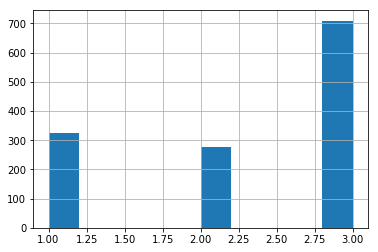

In [10]:
#2.travel class 
plt.gcf().clear()
titanic.pclass.hist().figure

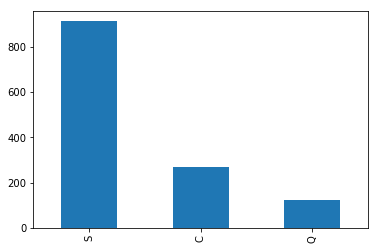

In [11]:
#2.embarkation port
#def parseHome (stri) :
#    return str(stri).split(",")[0]
#begTitanic = titanic
#begTitanic = titanic["home.dest"].dropna().map(parseHome, na_action=None)
#begPlot = begTitanic.value_counts().plot(kind='bar')
#begPlot.figure
plt.gcf().clear()
titanic.embarked.dropna().value_counts().plot(kind='bar').figure


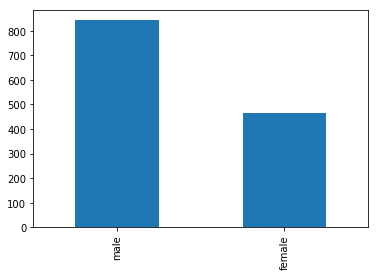

In [12]:
#2.sex 
plt.gcf().clear()
mfTitanic  = titanic["sex"].dropna().value_counts().plot(kind='bar')
mfTitanic.figure

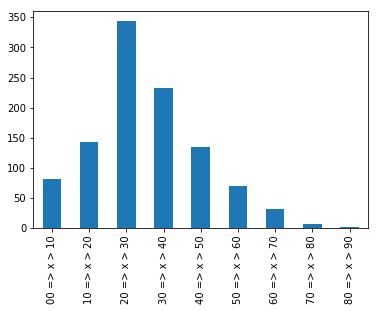

In [44]:
#2.age
plt.gcf().clear()
def ageToDecade (age) :
    return str(int(age/10)) + "0 => x > " + str(int(age/10)+1) + "0" 
ageTitanic = titanic["age"].dropna().map(ageToDecade).value_counts().sort_index().plot(kind='bar')
ageTitanic.figure

3    709
1    323
2    277
Name: pclass, dtype: int64


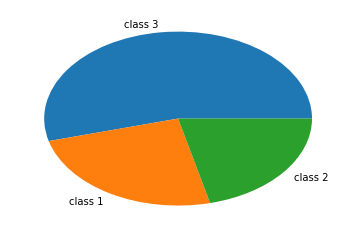

In [50]:
#3.cabin floor
plt.gcf().clear()
classTitanic = titanic['pclass'].dropna().value_counts()
plt.pie(classTitanic,labels=[ "class "  + str(x) for x in classTitanic.index.values])
plt.show()


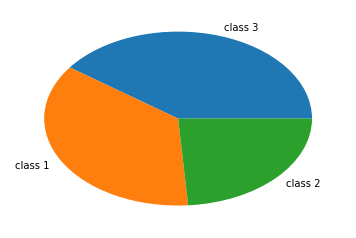

In [53]:
#4. survivor by class
plt.gcf().clear()
classSurvivorTitanic = titanic[titanic.survived ==1]['pclass'].dropna().value_counts()
plt.pie(classSurvivorTitanic,labels=[ "class "  + str(x) for x in classTitanic.index.values])
plt.show()

In [64]:
#4. survivor by class and sex
plt.gcf().clear()
classSexSurvivorTitanic = titanic[titanic.survived ==1][['pclass','sex']].dropna().count()
#plt.pie(classSexSurvivorTitanic,labels=[ "class "  + str(x) for x in classTitanic.index.values])
#plt.show()
classSexSurvivorTitanic

pclass  sex   
1       female    0
        male      0
        male      0
        female    0
        female    0
        female    0
        female    0
        female    0
        male      0
        female    0
        female    0
        male      0
        female    0
        male      0
        female    0
        female    0
        male      0
        female    0
        female    0
        male      0
        male      0
        female    0
        female    0
        female    0
        female    0
        male      0
        female    0
        female    0
        female    0
        female    0
                 ..
3       female    0
        male      0
        female    0
        female    0
        female    0
        female    0
        male      0
        male      0
        female    0
        female    0
        female    0
        female    0
        male      0
        male      0
        male      0
        male      0
        male      0
        male      0
     